# Example 4. Karate club network

In this example, we fit SBMs to the famous Zachary's Karate Club network[1]. The university's karate club has split up into two groups due to the internal conflict. The available information is the social interactions of 34 participants outside the club. The task is to separate the individuals into groups using this data, and the members of each faction are known. As the number of connections significantly varies among the persons, it was demonstrated that DCSBM better describes this network as the standard SBM, those treat the node's degree as the main feature[2].

![](images/karate_dcsbm.png)
#### Zachary's Karate club network divided into groups by DCSBM [2]

[1] W. W. Zachary, An information flow model for conflict and fission in small groups, Journal of Anthropological Research 33, 452-473 (1977).

[2] Brian Karrer and M. E. J. Newman, Stochastic blockmodels and community structure in networks, Phys. Rev. E 83, 016107 (2011).

In [1]:
import torch
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import matplotlib.pyplot as plt
from virgmo.vi_sbm import VI_SBM, VI_DCSBM
from virgmo.graph_models import SBM, DCSBM, EdgesDataset
import seaborn as sns
sns.reset_orig()
torch.manual_seed(42)

We start with the data import and aggregate the links into the adjacency matrix $A$. The true group assignments `z_true` are known.

In [2]:
karate = pd.read_csv('../data/karate', sep=' ')
N = 34
num_classes = 2
A = torch.zeros((N,N))
for e in np.array(karate):
    A[e[0]-1,e[1]-1] = 1
    A[e[1]-1,e[0]-1] = 1
    
z_true = torch.tensor([
    [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0]]).t()

Here is the network's adjacency matrix $A$.

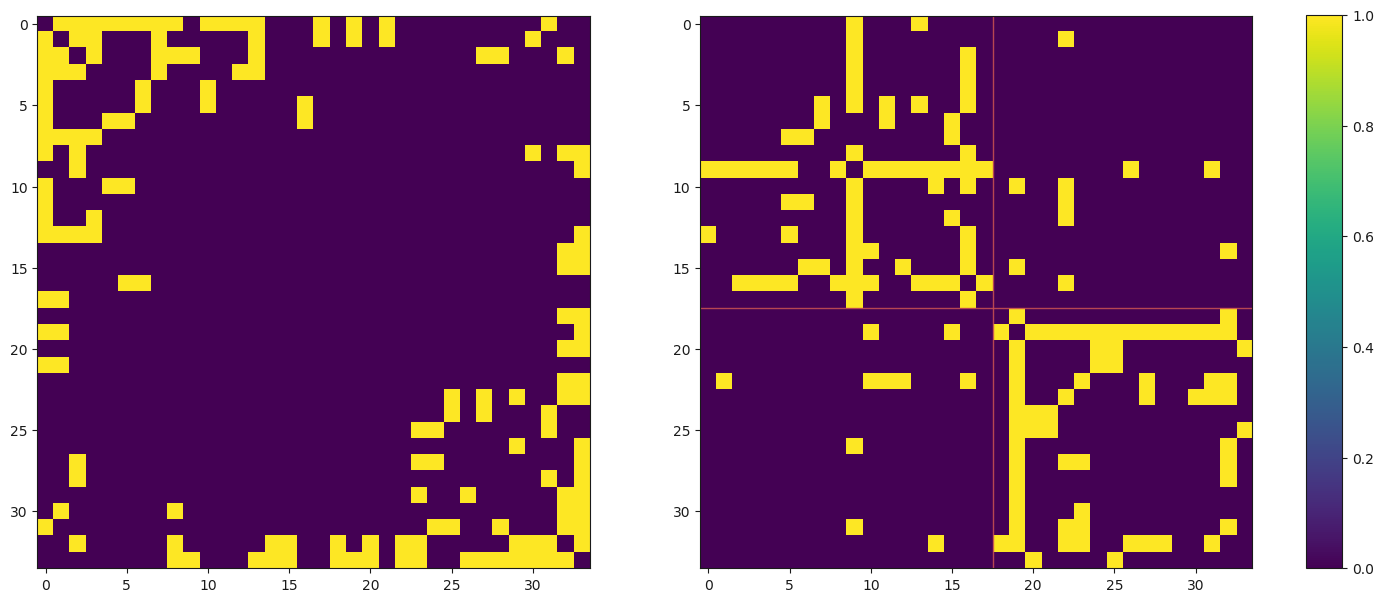

In [26]:
sns.reset_orig()
class_sizes = lambda classes: np.array(pd.Series(classes.numpy()).value_counts().sort_index())
cs = class_sizes(z_true.argmax(dim=1))
order = z_true.argmax(dim=1).argsort()
fig, axs = plt.subplots(1,2, figsize=(18,9))

axs[0].imshow(A.numpy(), cmap='viridis')
ax = axs[1].imshow(A[order,:][:,order].numpy(), cmap='viridis')
acc = -0.5
for i in cs[:-1]:
    acc += i
    axs[1].axvline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
    axs[1].axhline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.188, 0.02, 0.615])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
plt.savefig('../examples/images/ex4_A.pdf')
plt.show()

## SBM

First, we try the standard SBM. The default prior distribution in `VIRGMo` is quite flat but for this example we may use a more sharp one. We assume that the sizes of both groups are similar, and the nodes are connected densely within the groups as outside.

In [5]:
theta_p = torch.ones([num_classes])*5
w_p = torch.tensor([
        [[9., 1.], [1., 9.]],
        [[1., 9.], [9., 1.]]
        ])

dataloader = DataLoader(EdgesDataset(A.float()), 
                        batch_size=N, shuffle=True, num_workers=0)

vi = VI_SBM(num_nodes=N, num_classes=num_classes, 
                   priors={'theta_p':theta_p, 
                           'B_p':w_p},
                   init_values={'etas':None, 
                                'thetas':None, 
                                'Bs':None})
vi.multi_train(dataloader, epochs=20, lrs = [0.1, 0.05, 0.01], trials=20)

>>>>>>> Start multi-training...
>>> Trial 1/20 | Final loss: 426.49 | Trial time 8.72
>>> Trial 2/20 | Final loss: 426.36 | Trial time 4.81
>>> Trial 3/20 | Final loss: 425.73 | Trial time 6.60
>>> Trial 4/20 | Final loss: 425.45 | Trial time 5.78
>>> Trial 5/20 | Final loss: 488.18 | Trial time 6.08
>>> Trial 6/20 | Final loss: 426.15 | Trial time 5.67
>>> Trial 7/20 | Final loss: 425.63 | Trial time 5.62
>>> Trial 8/20 | Final loss: 425.58 | Trial time 5.67
>>> Trial 9/20 | Final loss: 425.49 | Trial time 5.66
>>> Trial 10/20 | Final loss: 426.13 | Trial time 5.74
>>> Trial 11/20 | Final loss: 425.86 | Trial time 6.83
>>> Trial 12/20 | Final loss: 425.95 | Trial time 7.10
>>> Trial 13/20 | Final loss: 425.58 | Trial time 5.25
>>> Trial 14/20 | Final loss: 426.21 | Trial time 7.14
>>> Trial 15/20 | Final loss: 425.59 | Trial time 6.45
>>> Trial 16/20 | Final loss: 425.62 | Trial time 5.18
>>> Trial 17/20 | Final loss: 425.83 | Trial time 9.08
>>> Trial 18/20 | Final loss: 425.63 | Tri

In [6]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [7]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B = vi.constrained_params()

In [8]:
vi.multi_results[1][best_trial]                     # Class probability of the best trial

tensor([0.7551, 0.2449])

In [9]:
print('True class probabilities:', z_true.sum(dim=0).float()/34)

True class probabilities: tensor([0.5294, 0.4706])


We see that the standard SBM struggles to find the correct class probabilities $\theta$. Let us look at the accuracy of the class assignments in all trials.

In [10]:
for i in range(len(vi.multi_results[0])):
    print(vi.class_accuracy(z_true,vi.multi_results[0][i]).item())

0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.529411792755127
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091


It is clear that the standart SBM does not suit for this task. Next, we try the DCSBM.

## DCSBM

Here, we use the same prior as for the SBM. As in the preivious examples we initialize $\delta$ with the observed degree distributions.

In [11]:
theta_p = torch.ones([num_classes])*5
w_p = torch.tensor([
        [[9., 1.], [1., 9.]],
        [[1., 9.], [9., 1.]]
        ])

In [12]:
delta_init = torch.ones([N,2])
delta_mu = A.sum(dim=1)/A.sum(dim=1).mean()
delta_init[:,0]=delta_mu.log().clone()
print('Contains infinities:', bool(torch.isinf(delta_init).sum().item()))

Contains infinities: False


In [13]:
dataloader = DataLoader(EdgesDataset(torch.tensor(A).float()), 
                        batch_size=N, shuffle=True, num_workers=0)

vi = VI_DCSBM(num_nodes=N, num_classes=num_classes, 
                   priors={'theta_p':theta_p, 
                           'B_p':w_p,
                           'delta_p':None},
                   init_values={'etas':None, 
                                'thetas':None, 
                                'Bs':None,
                                'deltas':delta_init})
vi.multi_train(dataloader, epochs=20, lrs = [0.1, 0.05, 0.01], trials=10)

>>>>>>> Start multi-training...


 /home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor). 


>>> Trial 1/10 | Final loss: 356.92 | Trial time 13.26
>>> Trial 2/10 | Final loss: 354.96 | Trial time 9.82
>>> Trial 3/10 | Final loss: 350.87 | Trial time 10.81
>>> Trial 4/10 | Final loss: 355.56 | Trial time 13.27
>>> Trial 5/10 | Final loss: 355.42 | Trial time 13.43
>>> Trial 6/10 | Final loss: 358.47 | Trial time 10.75
>>> Trial 7/10 | Final loss: 350.66 | Trial time 10.29
>>> Trial 8/10 | Final loss: 354.65 | Trial time 14.32
>>> Trial 9/10 | Final loss: 351.21 | Trial time 13.15
>>> Trial 10/10 | Final loss: 353.98 | Trial time 12.62


In [14]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [15]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B, q_delta = vi.constrained_params()

In [16]:
vi.multi_results[1][best_trial]                     # Class probability of the best trial

tensor([0.4748, 0.5252])

In [17]:
theta_true = z_true.sum(dim=0).float()/34

In [18]:
print('True class probabilities:', theta_true)

True class probabilities: tensor([0.5294, 0.4706])


Again, let us look at the class acuracy.

In [19]:
for i in range(len(vi.multi_results[0])):
    print(vi.class_accuracy(z_true,vi.multi_results[0][i]).item())

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


The class assignments of the DCSBM is correct in the majority of the trials. Further, we may inspect the estimated $\theta$ and $B$ distributions.

In [20]:
permutation = [1,0]
q_theta_perm = q_theta.detach()[permutation]
num_samples = 1000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

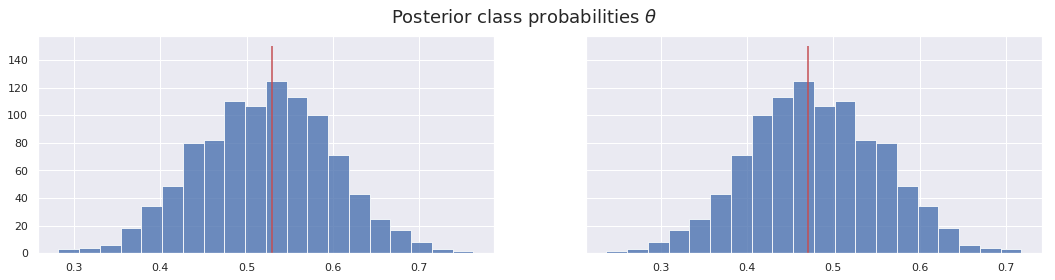

In [23]:
sns.set()
fig, axs = plt.subplots(1, num_classes, figsize=(18,4), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(theta_true[i], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
#plt.savefig('../examples/images/ex4_theta_dcsbm.pdf')
plt.show()

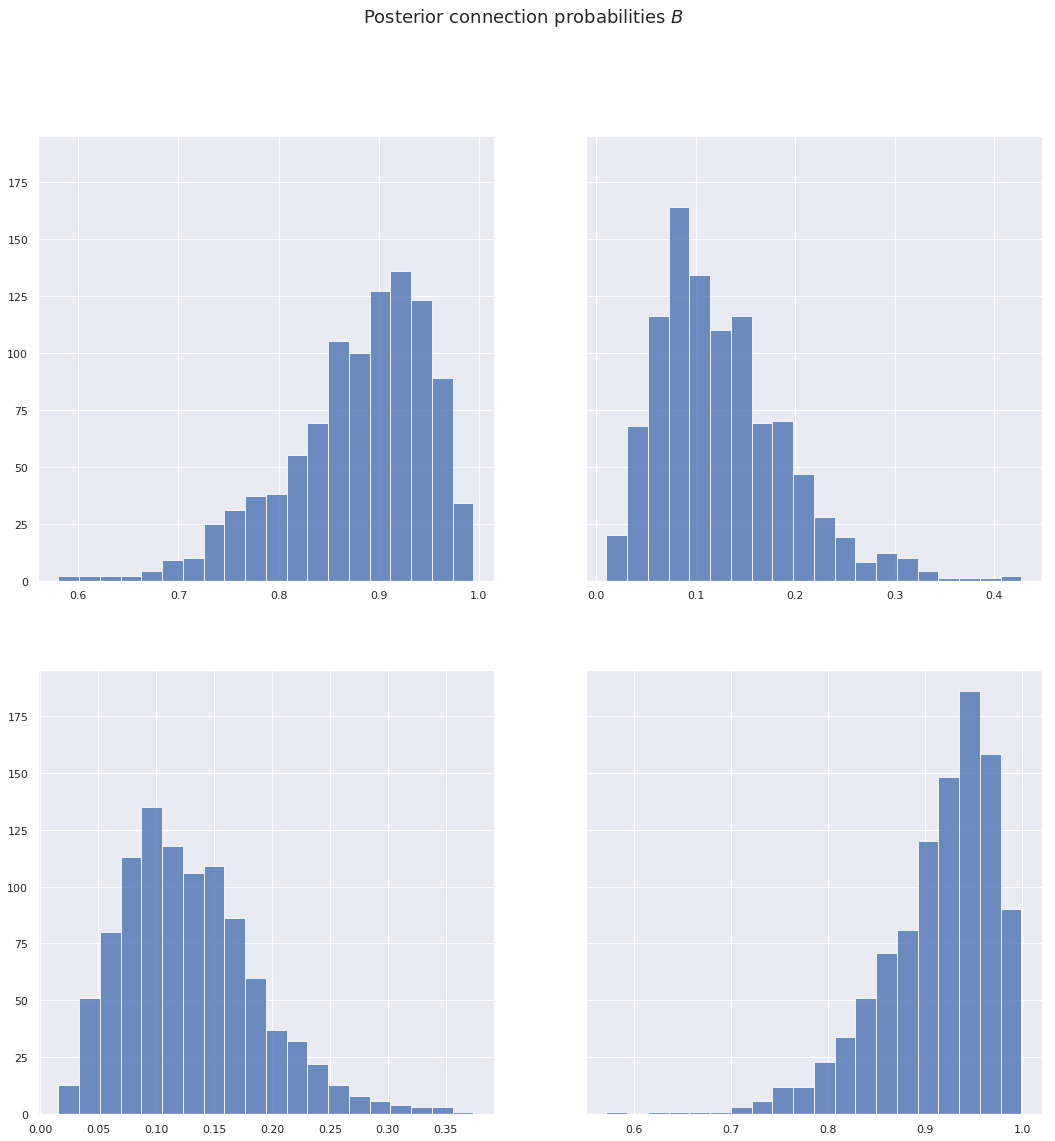

In [24]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
#plt.savefig('../examples/images/ex4_B_dcsbm.pdf')
plt.show()